In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import gradio as gr                                     
from Constants import *

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [9]:
train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [10]:
test.head(1)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


In [11]:
test_labels.head(1)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1


In [12]:
submissn.head(1)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5


In [13]:
train.iloc[1]

id                                                000103f0d9cfb60f
comment_text     D'aww! He matches this background colour I'm s...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
Name: 1, dtype: object

In [14]:
train[train.columns[2:]].iloc[1]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64

In [15]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [16]:
X = train['comment_text']
y = train[train.columns[2:]].values

In [17]:
MAX_FEATURES = 10000
sequence_length = 1000

vectoriser = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_sequence_length = sequence_length,
    output_mode = 'int'
)

In [18]:
vectoriser.adapt(X.values)

vectoriser("Hello world this is your daily dose of internet, curated for yoy")
vectoriser.get_vocabulary()[7]

'you'

In [19]:
vectorised_text = vectoriser(X.values)
vectorised_text

<tf.Tensor: shape=(159571, 1000), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]], dtype=int64)>

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [33]:
X_batch, y_batch = dataset.as_numpy_iterator().next()

In [34]:
train_set = dataset.take(int(len(dataset) * 0.7))
val_set = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_set = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [35]:
train_generator = train_set.as_numpy_iterator()

In [36]:
train_generator.next()

(array([[   8,   69,    2, ...,    0,    0,    0],
        [   1, 1961,   41, ...,    0,    0,    0],
        [1553,    1,   24, ...,    0,    0,    0],
        ...,
        [  84,   21, 1502, ...,    0,    0,    0],
        [6973, 4040,    4, ...,    0,    0,    0],
        [   1, 6070,    1, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [18]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh', return_sequences = True)),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(6, activation = 'sigmoid')
])

In [19]:
model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy'#,metrics = ['accuracy']
)

In [20]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = 32,
                    verbose = 2,
                    epochs = 10
                    )

Epoch 1/10


6981/6981 - 2754s - loss: 0.0627 - val_loss: 0.0511 - 2754s/epoch - 395ms/step
Epoch 2/10
6981/6981 - 2582s - loss: 0.0497 - val_loss: 0.0466 - 2582s/epoch - 370ms/step
Epoch 3/10
6981/6981 - 2608s - loss: 0.0461 - val_loss: 0.0429 - 2608s/epoch - 374ms/step
Epoch 4/10
6981/6981 - 2641s - loss: 0.0437 - val_loss: 0.0409 - 2641s/epoch - 378ms/step
Epoch 5/10
6981/6981 - 2579s - loss: 0.0405 - val_loss: 0.0371 - 2579s/epoch - 369ms/step
Epoch 6/10
6981/6981 - 2584s - loss: 0.0383 - val_loss: 0.0358 - 2584s/epoch - 370ms/step
Epoch 7/10
6981/6981 - 2741s - loss: 0.0365 - val_loss: 0.0333 - 2741s/epoch - 393ms/step
Epoch 8/10
6981/6981 - 2567s - loss: 0.0342 - val_loss: 0.0306 - 2567s/epoch - 368ms/step
Epoch 9/10
6981/6981 - 2556s - loss: 0.0324 - val_loss: 0.0284 - 2556s/epoch - 366ms/step
Epoch 10/10
6981/6981 - 2569s - loss: 0.0307 - val_loss: 0.0276 - 2569s/epoch - 368ms/step


In [21]:
loss = model.evaluate(test_set)

997/997 [==============================] - 74s 73ms/step - loss: 0.0272


In [22]:
history = history.history

In [23]:
val_loss = history['val_loss']
loss = history['loss']

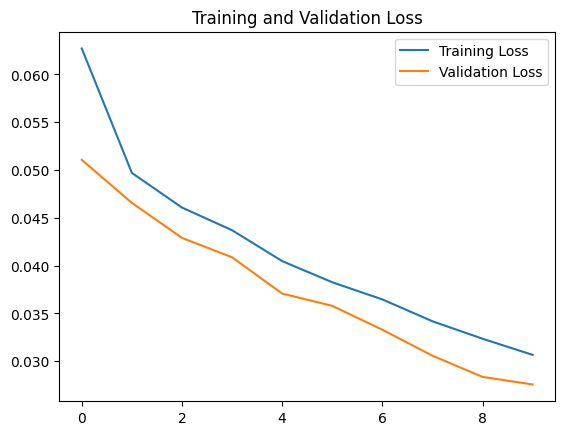

In [24]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [26]:
train.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [20]:
# Making predictions

sample_text = vectoriser("You idiot i will kill you, you black scum!")

In [21]:
model.predict(np.expand_dims(sample_text, 0))

1/1 [==============================] - 5s 5s/step


array([[0.9996739 , 0.1431852 , 0.9491504 , 0.05712875, 0.94148004,
        0.9084311 ]], dtype=float32)

In [ ]:
test_batch_X, test_batch_y = test_set.as_numpy_iterator().next()

In [ ]:
(model.predict(test_batch_X) > 0.5).astype(int)

In [30]:
test_batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [24]:
precision = Precision()
recall = Recall()
#accuracy = CategoricalAccuracy()

In [32]:
for batch in test_set.as_numpy_iterator():
    X_true, y_true = batch
    y_pred = model.predict(X_true)
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    accuracy.update_state(y_true, y_pred)
    
    return None

1/1 [==============================] - 0s 105ms/step


In [25]:
print(f"Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}")
      #, Accuracy: {accuracy.result().numpy()}")

Precision: 0.0, Recall: 0.0


In [35]:
model.save("toxic_comments.h5")

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model = tf.keras.models.load_model("toxic_comments.h5")

In [38]:
sample_text = vectoriser("I will kill you, i hate your kind")

In [39]:
result = model.predict(np.expand_dims(sample_text, 0))
result

1/1 [==============================] - 2s 2s/step


array([[0.99260706, 0.11885089, 0.03767445, 0.8577647 , 0.09559225,
        0.05044971]], dtype=float32)

In [45]:
def score_comment(comment):
    vectorised_comment = vectoriser([comment])
    result = model.predict(vectorised_comment)
    
    text = ''
    for idx, col in enumerate(train.columns[2:]):
        text += "{}: {}\n".format(col, result[0][idx] > 0.5)
        
    return text

In [46]:
import gradio as gr

interface = gr.Interface(
    score_comment,
    gr.Textbox(lines = 3, placeholder = "User Comment"),
    "text"
)

In [47]:
interface.launch(share = True)

Running on local URL:  http://127.0.0.1:7865

Could not create share link. Missing file: c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio


1/1 [==============================] - 0s 112ms/step
